In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('xrp_open.csv')
print(df)

      Unnamed: 0 formatted_date      high       low      open     close  \
0              0     2019-01-01  0.364771  0.350402  0.365675  0.364771   
1              1     2019-01-02  0.378021  0.359574  0.374505  0.375243   
2              2     2019-01-03  0.374505  0.357675  0.359753  0.360224   
3              3     2019-01-04  0.364642  0.352785  0.356347  0.356747   
4              4     2019-01-05  0.361069  0.353987  0.354750  0.355275   
...          ...            ...       ...       ...       ...       ...   
1515        1515     2023-02-24  0.390547  0.374133  0.378507  0.378477   
1516        1516     2023-02-25  0.379419  0.372250  0.378085  0.378085   
1517        1517     2023-02-26  0.380606  0.375420  0.378005  0.378041   
1518        1518     2023-02-27  0.380042  0.372158  0.379121  0.379115   
1519        1519     2023-02-28  0.382433  0.373027  0.377133  0.377150   

          volume  adjclose  
0      449347622  0.364771  
1      543216669  0.375243  
2      43887

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv("/BOOSTING/bitcoin_processed_close.csv")
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,0.322593,0.317439,0.321078,0.320790,363940431,0.320790,0.005154,0.326430,0.333398,0.343423,0.004046,0.019639
21,21,2019-01-22,0.321078,0.313455,0.319566,0.319491,434125854,0.319491,0.007623,0.325376,0.330090,0.341227,0.004784,0.019605
22,22,2019-01-23,0.320303,0.314923,0.316416,0.316492,375671478,0.316492,0.005380,0.323480,0.326158,0.338461,0.005382,0.018754
23,23,2019-01-24,0.318896,0.314433,0.317859,0.317598,344960253,0.317598,0.004463,0.321860,0.325199,0.336466,0.005072,0.018603
24,24,2019-01-25,0.319069,0.313824,0.317260,0.317165,360076505,0.317165,0.005245,0.320654,0.324074,0.334605,0.005010,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,0.390547,0.374133,0.378507,0.378477,953355531,0.378477,0.016414,0.390655,0.387824,0.390458,0.006728,0.010027
1516,1516,2023-02-25,0.379419,0.372250,0.378085,0.378085,552223148,0.378085,0.007169,0.388296,0.387403,0.388878,0.007907,0.009161
1517,1517,2023-02-26,0.380606,0.375420,0.378005,0.378041,441815645,0.378041,0.005186,0.387100,0.387600,0.387880,0.008825,0.009149
1518,1518,2023-02-27,0.380042,0.372158,0.379121,0.379115,1049508853,0.379115,0.007884,0.384329,0.388137,0.387227,0.007603,0.009266


In [4]:
pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

300
(1193, 7, 9) (1193, 1) (300, 7, 9) (300, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_open.h5")

Epoch 1/120
40/40 [==============================] - 13s 19ms/step - loss: 0.0120
Epoch 2/120
40/40 [==============================] - 1s 23ms/step - loss: 0.0053
Epoch 3/120
40/40 [==============================] - 1s 25ms/step - loss: 0.0040
Epoch 4/120
40/40 [==============================] - 1s 27ms/step - loss: 0.0044
Epoch 5/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0037
Epoch 6/120
40/40 [==============================] - 1s 18ms/step - loss: 0.0038
Epoch 7/120
40/40 [==============================] - 1s 24ms/step - loss: 0.0037
Epoch 8/120
40/40 [==============================] - 1s 22ms/step - loss: 0.0030
Epoch 9/120
40/40 [==============================] - 1s 26ms/step - loss: 0.0031
Epoch 10/120
40/40 [==============================] - 1s 23ms/step - loss: 0.0032
Epoch 11/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0028
Epoch 12/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

38/38 [==============================] - 2s 5ms/step
      predict_price  y_train_price  error_price
0          0.307347       0.295060     0.012287
1          0.293960       0.289425     0.004535
2          0.290594       0.320704    -0.030110
3          0.313939       0.310839     0.003100
4          0.307822       0.308326    -0.000504
...             ...            ...          ...
1188       0.616588       0.587086     0.029502
1189       0.598902       0.607819    -0.008918
1190       0.601515       0.614218    -0.012703
1191       0.604525       0.604804    -0.000279
1192       0.601153       0.646463    -0.045310

[1193 rows x 3 columns]


In [7]:
import pickle
from sklearn.linear_model import ElasticNet

elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_open.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

10/10 [==============================] - 0s 5ms/step
[[0.2907568 ]
 [0.26270562]
 [0.27067304]
 [0.25434715]
 [0.24967551]
 [0.21572034]
 [0.22161965]
 [0.16094147]
 [0.14902286]
 [0.16809455]
 [0.15695833]
 [0.17284405]
 [0.1631836 ]
 [0.16747789]
 [0.15764472]
 [0.15796232]
 [0.15678102]
 [0.15472008]
 [0.15732376]
 [0.15081201]
 [0.14907745]
 [0.14977375]
 [0.14193328]
 [0.13991885]
 [0.14060593]
 [0.14045057]
 [0.15791208]
 [0.1622371 ]
 [0.14955127]
 [0.15332477]
 [0.14435747]
 [0.14543758]
 [0.14740968]
 [0.15116383]
 [0.15063475]
 [0.15074256]
 [0.14991644]
 [0.14201826]
 [0.13166942]
 [0.12263513]
 [0.10347322]
 [0.10369935]
 [0.11070363]
 [0.09848231]
 [0.10599691]
 [0.09358656]
 [0.10551491]
 [0.1034272 ]
 [0.10929975]
 [0.10288891]
 [0.112637  ]
 [0.13367061]
 [0.12902549]
 [0.12940726]
 [0.12423877]
 [0.11647039]
 [0.11143569]
 [0.10902017]
 [0.10424001]
 [0.10231931]
 [0.10415006]
 [0.10654127]
 [0.10580245]
 [0.11102951]
 [0.11627334]
 [0.11821277]
 [0.11865314]
 [0.10803

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[0.6366877 ]
 [0.58909166]
 [0.6026104 ]
 [0.5749094 ]
 [0.56698275]
 [0.5093691 ]
 [0.5193788 ]
 [0.41642264]
 [0.39619964]
 [0.42855966]
 [0.4096642 ]
 [0.43661842]
 [0.420227  ]
 [0.4275134 ]
 [0.41082886]
 [0.41136774]
 [0.40936336]
 [0.40586644]
 [0.41028425]
 [0.3992354 ]
 [0.39629227]
 [0.39747372]
 [0.38417035]
 [0.38075235]
 [0.38191816]
 [0.38165456]
 [0.41128248]
 [0.418621  ]
 [0.39709625]
 [0.40349895]
 [0.3882836 ]
 [0.3901163 ]
 [0.39346248]
 [0.39983237]
 [0.39893463]
 [0.39911756]
 [0.39771584]
 [0.38431454]
 [0.36675507]
 [0.35142606]
 [0.31891298]
 [0.3192967 ]
 [0.33118123]
 [0.31044462]
 [0.32319507]
 [0.30213773]
 [0.32237723]
 [0.3188349 ]
 [0.3287992 ]
 [0.31792155]
 [0.3344617 ]
 [0.37015063]
 [0.36226898]
 [0.36291674]
 [0.35414708]
 [0.34096602]
 [0.33242336]
 [0.32832482]
 [0.32021403]
 [0.3169551 ]
 [0.32006142]
 [0.32411873]
 [0.3228651 ]
 [0.33173415]
 [0.34063166]
 [0.3439224 ]
 [0.34466964]
 [0.32665175]
 [0.32039532]
 [0.3149229 ]
 [0.32041153]
 [0.32

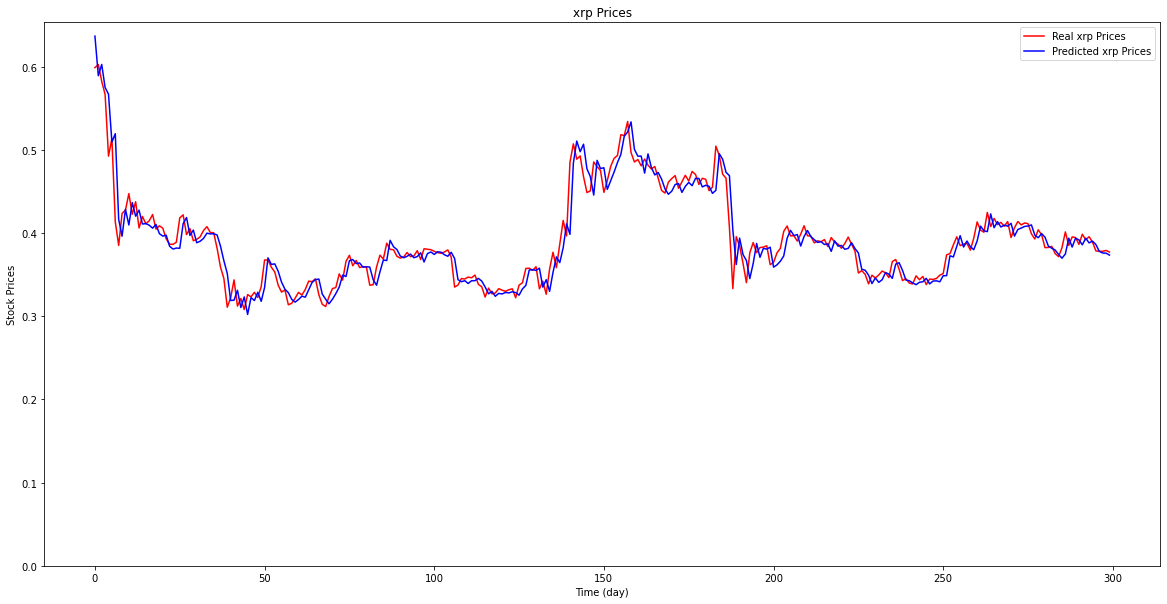

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real xrp Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted xrp Prices")
plt.title(f"xrp Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.01
MAPE: 2.93%
MSE: 0.00
RMSE: 0.02
R2: 0.90


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))